In [1]:
# import initial libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pandas_datareader import data as wb
import datetime
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# import market returns
apple = wb.DataReader('AAPL', data_source="yahoo", start= '2010/1/31', end='2020/04/10')
apple_1 = apple[['Adj Close']] #took volume out
#apple_2 = (apple['High'] - apple['Low']) / apple['High']
apple_data = pd.concat([apple_1], axis = 'columns') #took out apple_2
#columns = ['bid_ask_spread', 'Volume', 'Adj Close']
#apple_data.columns=columns

In [3]:
apple_data

,Adj Close
Date,
2010-02-01,24.147655
2010-02-02,24.287779
2010-02-03,24.705675
2010-02-04,23.815323
2010-02-05,24.238180
...,...
2020-04-03,241.410004
2020-04-06,262.470001
2020-04-07,259.429993


In [4]:
# import ffm 5 factor
path = Path('F-F_Research_Data_5_Factors_2x3_daily.CSV')
ffm_5 = pd.read_csv(path, index_col ='Date', infer_datetime_format=True)
ffm_5.index = pd.DatetimeIndex(ffm_5.index)

In [5]:
data = pd.concat([apple_data, ffm_5], axis =1 , join ='inner')
data = data.reindex(columns =['Mkt-RF', 'SMB', 'HML','RMW', 'CMA', 'RF','Adj Close']) # 'bid_ask_spread','Volume', 

In [6]:
data

,Mkt-RF,SMB,HML,RMW,CMA,RF,Adj Close
Date,,,,,,,
2010-02-01,1.39,-0.14,0.91,-0.14,0.69,0.000,24.147655
2010-02-02,1.21,-0.32,0.66,0.19,0.69,0.000,24.287779
2010-02-03,-0.49,0.05,-0.38,0.18,-0.15,0.000,24.705675
2010-02-04,-3.14,-0.34,-1.19,0.41,-0.03,0.000,23.815323
2010-02-05,0.29,-0.07,-0.06,-0.58,-0.16,0.000,24.238180
...,...,...,...,...,...,...,...
2020-02-24,-3.38,0.15,-0.04,-0.37,0.20,0.006,298.179993
2020-02-25,-3.09,-0.34,-0.72,-0.63,0.03,0.006,288.079987
2020-02-26,-0.52,-0.79,-1.26,-0.52,-0.12,0.006,292.649994


In [7]:
# create a new dataframe with only close column
data = data.filter(['Adj Close'])
#convet the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

2030

In [8]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [9]:
#Creat the training data set
#creat the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into X_train and y_train data set
X_train= []
y_train = []

for i in range (6, len(train_data)):
  X_train.append(train_data[i-6:i,0])   #will contain 60 values. index 0 to 59
  y_train.append(train_data[i,0]) #will conrain 61st value.  index 60
  

In [10]:
#convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [22]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_train.shape

(2024, 6, 1)

In [24]:
# Bulid the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences= True,  input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [25]:
#Complie model
model.compile(optimizer='adam', loss='mean_squared_error')  #loss show how well the model did in training

In [26]:
# Train the model
model.fit(X_train, y_train, batch_size= 10, epochs=50, verbose=1 )

Train on 2024 samples
Epoch 1/50
2024/2024 [==============================] - 3s 2ms/sample - loss: 0.0021
Epoch 2/50
2024/2024 [==============================] - 1s 506us/sample - loss: 7.0580e-05
Epoch 3/50
2024/2024 [==============================] - 1s 501us/sample - loss: 7.4095e-05
Epoch 4/50
2024/2024 [==============================] - 1s 499us/sample - loss: 7.2938e-05
Epoch 5/50
2024/2024 [==============================] - 1s 497us/sample - loss: 6.9802e-05
Epoch 6/50
2024/2024 [==============================] - 1s 500us/sample - loss: 8.1631e-05
Epoch 7/50
2024/2024 [==============================] - 1s 498us/sample - loss: 8.5758e-05
Epoch 8/50
2024/2024 [==============================] - 1s 497us/sample - loss: 8.4278e-05
Epoch 9/50
2024/2024 [==============================] - 1s 501us/sample - loss: 8.8377e-05
Epoch 10/50
2024/2024 [==============================] - 1s 506us/sample - loss: 6.9699e-05
Epoch 11/50
2024/2024 [==============================] - 1s 502us/sample 

In [27]:
#create the teating data set
#create a new array containing scaled values from index  
test_data = scaled_data[training_data_len - 6:,:]
#Create the data sets X_test and y_test
X_test = []
y_test= dataset[training_data_len:,:]
for i in range(6, len(test_data)):
    X_test.append(test_data[i-6:i,0])


In [28]:
# Convert the data to a numpy array
X_test = np.array(X_test)

In [29]:
# Reshape the data
X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [30]:
#Get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


In [31]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

4.3034345906773614

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


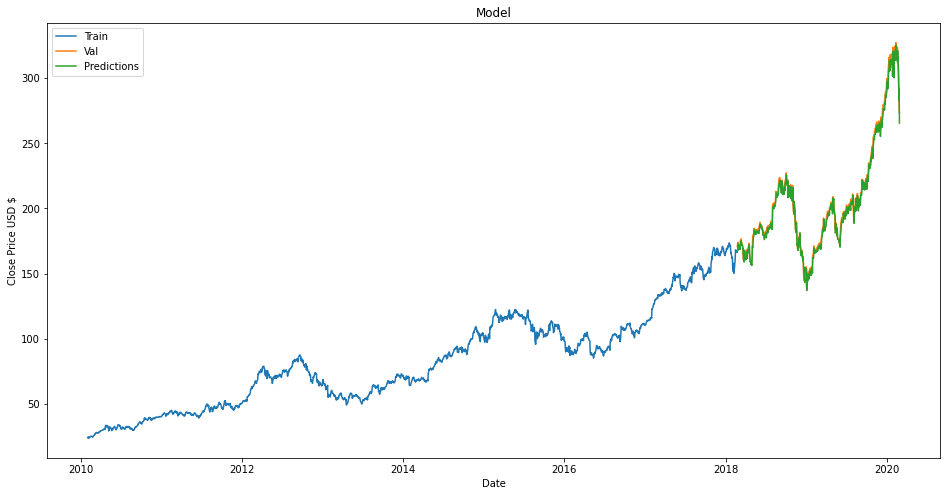

In [32]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visulize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel('Close Price USD $')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.legend(["Train", 'Val','Predictions'])
plt.show()

In [33]:
# show the valid and predicted prices
valid

,Adj Close,Predictions
Date,,
2018-02-23,170.634277,166.494446
2018-02-26,174.008057,169.531952
2018-02-27,173.444168,172.809525
2018-02-28,173.181656,171.644135
2018-03-01,170.148117,171.578354
...,...,...
2020-02-24,298.179993,307.071014
2020-02-25,288.079987,290.713196
2020-02-26,292.649994,283.291138
